# Attacking AES in CTR mode in 256 traces without knowing the nonce

In [1]:
import numpy as np
from numpy.linalg import lstsq
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math
from tqdm import tqdm_notebook
import seaborn as sns
import random

Some AES functions:

In [2]:
sbox=[0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
  0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
  0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
  0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
  0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
  0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
  0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
  0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
  0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
  0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
  0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
  0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
  0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
  0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
  0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
  0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16]
sbox_inv = [0]*256
for i in range(256):
    sbox_inv[sbox[i]]=i
hw = [0,1,1,2,1,2,2,3,1,2,2,3,2,3,3,4,1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,
  1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
  1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
  2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
  1,2,2,3,2,3,3,4,2,3,3,4,3,4,4,5,2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,
  2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
  2,3,3,4,3,4,4,5,3,4,4,5,4,5,5,6,3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,
  3,4,4,5,4,5,5,6,4,5,5,6,5,6,6,7,4,5,5,6,5,6,6,7,5,6,6,7,6,7,7,8]

In [3]:
def timestwo(x):
    return ((x<<1)&0xff) ^ (((x>>7)&0x1)*0x1b)
def timesthree(x):
    return x^timestwo(x)
def timesfour(x):
    return timestwo(timestwo(x))
def timeseight(x):
    return timestwo(timesfour(x))

In [4]:
def mixcol(x,factor,constant):
    if factor==1:
        return x^constant
    elif factor==2:
        return timestwo(x)^constant
    else:
        return timesthree(x)^constant

#### Pick a device and Load the traces

In [5]:
DEVICE = "CORTEX"
# DEVICE = "DUINO"
# DEVICE = "XMEGA"

In [6]:
if DEVICE=="CORTEX":
    powertraces = np.load('cortex_traces.npy')
elif DEVICE=="DUINO":
    powertraces = np.load('duino_traces.npy')
else:
    assert(DEVICE=="XMEGA")
    powertraces = np.load('xmega_traces.npy')

In [7]:
[nr_of_meas,len_trace] = powertraces.shape
nr_of_meas, len_trace

(256, 12000)

<IPython.core.display.Javascript object>


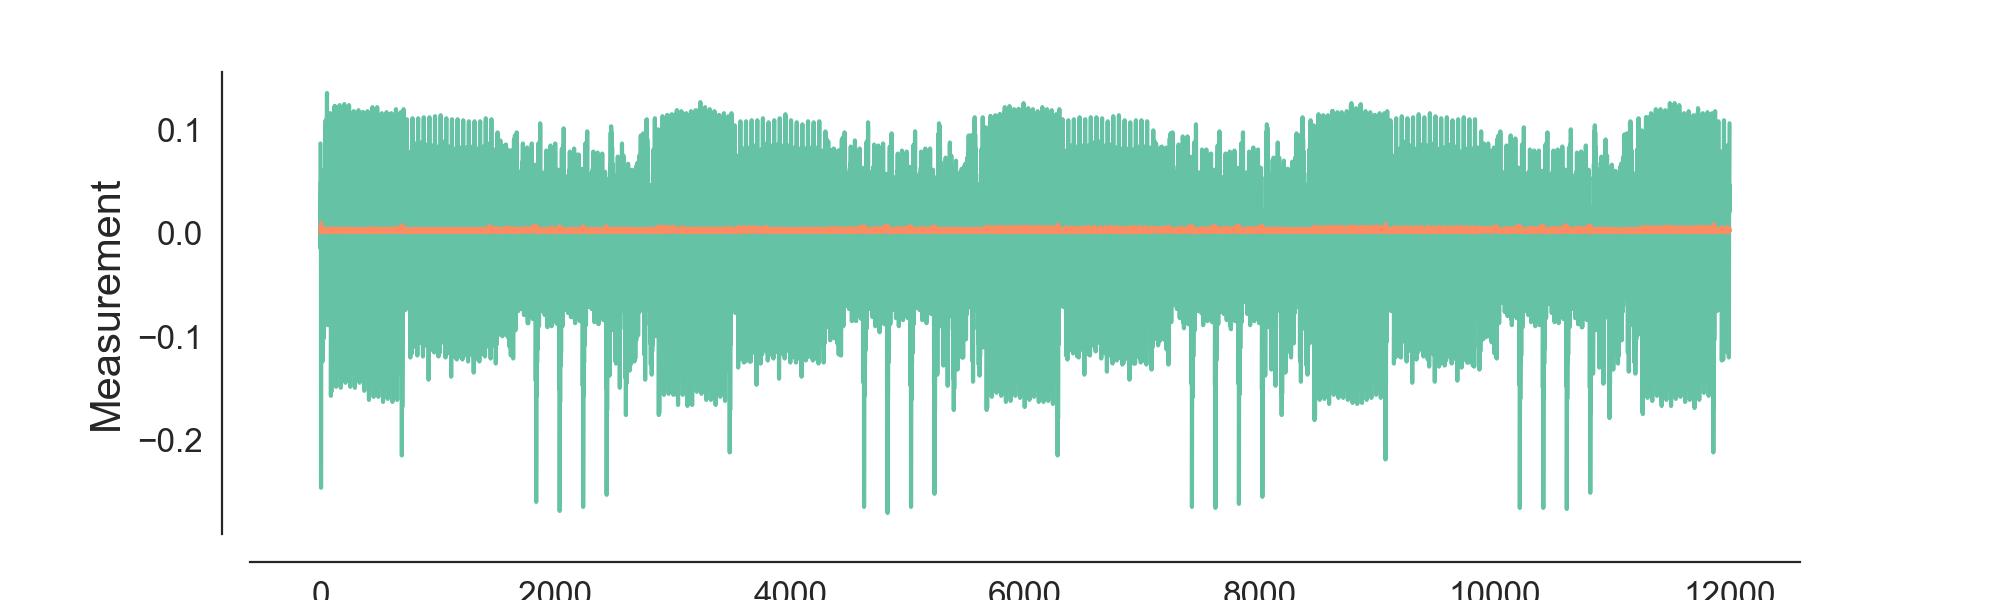

In [8]:
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 12})
sns.set_style("white")
sns.set_palette(sns.color_palette("Set2"))
plt.figure(figsize=(10,3))
plt.plot(powertraces[0])
plt.plot(np.std(powertraces,axis=0))
plt.xlabel('Time [samples]',FontSize=15)
plt.ylabel('Measurement',FontSize=15)
sns.despine(offset=10)

We use the trace plot to estimate the start and end of each subbytes execution. This step is not necessary but makes the rest of this notebook more efficient. The nice thing about CPA is that it can be applied to the entire trace if the point of interest is not known. In some devices, the round transformations are not easily distinguishable in a trace. In that case, the attack can still be performed with larger regions of interest. It will only take a bit longer. 

In [9]:
if DEVICE=="CORTEX":
    x_range1 = range(700,1500)
    x_range2 = range(3500,4300)
    x_range3 = range(6300,7100)
    x_range4 = range(9100,9900)
elif DEVICE=="DUINO":
    x_range1 = range(96445,99213) # this is very limited, just to make the notebook faster. 
    x_range2 = range(196000,221000)
    x_range3 = range(319000,344000)
    x_range4 = range(441000,466000)
else:
    assert(DEVICE=="XMEGA")
    x_range1 = range(867,1667)
    x_range2 = range(6100,6900)
    x_range3 = range(11343,12143)
    x_range4 = range(16587,17387)

## Round 1
This is the most complex step of the attack since we have to loop over $1<<15$ hypotheses.
The smaller the region we can pinpoint for this the better.

In [10]:
def round1():
    # initialize records
    maxcors = np.empty((1<<15))
    cors = np.empty(len(x_range1))
    hypos = np.empty(nr_of_meas)
    # start loop to compute hypotheses
    for guess in tqdm_notebook(range(1<<15)):
        b = (guess>>14)&0x1
        nonceguess = (guess>>7)&0x7F
        keyguess = guess&0x7F
        for i in range(nr_of_meas):
            counter = (nonceguess+i)&0xFF
            hypos[i] = hw[sbox[keyguess^counter^(b<<7)]]
        # compute the Pearson Correlation
        cors = [pearsonr(powertraces[:,j],hypos)[0] for j in x_range1]
        maxcors[guess] = np.max(np.abs(cors))
    # sort the hypotheses by the maximum absolute correlation
    ranked_guesses = sorted(range(1<<15), key=lambda k: maxcors[k], reverse=True)
    for g in ranked_guesses[:10]:
        print hex((g>>7)&0xFF), hex(g&0x7F), maxcors[g]
    # we include bit b in the nonce, assuming for now that the most significant bit of the key byte is 0
    # this does not make a difference for the rest of the attack
    return (ranked_guesses[0]>>7)&0xFF, ranked_guesses[0]&0x7F,ranked_guesses[:10]

In [ ]:
nonce1,key1,ranked_guesses = round1()

We didn't save all the correlation traces because this would take a lot of memory. 
To plot the correlation traces of the 10 best hypotheses, use the following:

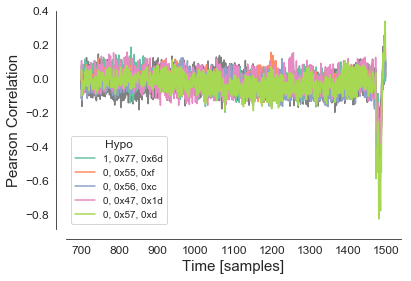

In [12]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
sns.set_style("white")
sns.set_palette(sns.color_palette("Set2"))
hypos = np.empty(nr_of_meas)
for i,g in enumerate(ranked_guesses[::-1]):
    b = (g>>14)&0x1
    nonceguess = (g>>7)&0x7F
    keyguess = g&0x7F
    for j in range(nr_of_meas):
        counter = (nonceguess+j)&0xFF
        hypos[j] = hw[sbox[keyguess^counter^(b<<7)]]
    cors = [pearsonr(powertraces[:,j],hypos)[0] for j in x_range1]
    if i<5:
        plt.plot(x_range1,cors,color="grey")
    else:
        plt.plot(x_range1,cors,label="%d, 0x%x, 0x%x"%(b,keyguess,nonceguess))
plt.legend(loc="lower left",title="Hypo",prop={'size': 10})
plt.xlabel('Time [samples]',FontSize=15)
plt.ylabel('Pearson Correlation',FontSize=15)
sns.despine(offset=10)

We continue to the next round with the following key and nonce byte:

In [13]:
print hex(key1),hex(nonce1)

0x57 0xd


As an extra check, we can perform regular CPA with the found nonce:


0x57 0.8237508829434164
0x54 0.33816498802874945
0x55 0.3304635079701237
0x56 0.3290632388685554
0x44 0.26852453820541555
0x2 0.2634393266772059
0x28 0.2634191071325582
0x79 0.25939485841809384
0x5a 0.2525268153981269
0xee 0.25230337378120277


87

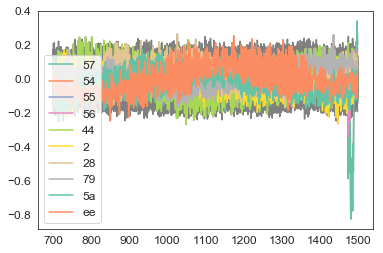

In [14]:
# regular cpa
def classiccpa(nonce):
    maxcors = np.empty(256)
    cors = np.empty((256,len(x_range1)))
    hypos = np.empty(nr_of_meas)
    for keyguess in tqdm_notebook(range(256)):
        for i in range(nr_of_meas):
            counter = (nonce+i)&0xFF
            hypos[i] = hw[sbox[keyguess^counter]]
        cors[keyguess] = [pearsonr(powertraces[:,j],hypos)[0] for j in x_range1]
        plt.plot(x_range1,cors[keyguess],color="grey")
        maxcors[keyguess] = np.max(np.abs(cors[keyguess]))
    ranked_guesses = sorted(range(256), key=lambda k: maxcors[k], reverse=True)
    for g in ranked_guesses[:10]:
        print hex(g), maxcors[g]
        plt.plot(x_range1,cors[g],label="%x"%g)
    plt.legend(loc='lower left')
    return ranked_guesses[0]
classiccpa(nonce1)

## Round 2
We first create an array of factors to use for the MixColumns operation

In [15]:
factors = [1,1,3,2]

In [16]:
def round2(byte,plotit):
    maxcors = np.empty(256)
    cors = np.empty((256,len(x_range2)))
    hypos = np.empty(nr_of_meas)
    for guess in tqdm_notebook(range(256)):
        for i in range(nr_of_meas):
            alpha = sbox[key1^((nonce1+i)&0xff)]
            hypos[i] = hw[sbox[mixcol(alpha,factors[byte],guess)]]
        cors[guess] = [pearsonr(powertraces[:,j],hypos)[0] for j in x_range2]
        if(plotit): plt.plot(x_range2,cors[guess],color="grey")
        maxcors[guess] = np.max(np.abs(cors[guess]))
    ranked_guesses = sorted(range(256), key=lambda k: maxcors[k], reverse=True)
    if(plotit):
        for g in ranked_guesses[:5]:
            print hex(g), maxcors[g]
            plt.plot(x_range2,cors[g],label="0x%x"%g)
        plt.legend(loc="right")
    return ranked_guesses[0], ranked_guesses[1], np.argmax(np.abs(cors[ranked_guesses[0]])), np.argmax(np.abs(cors[ranked_guesses[1]]))

You can see the results of attacking one byte here by choosing BYTE $\in \{0,1,2,3\}$.
Remember that those with MixColumns factor 1 go together, so BYTE=0 and BYTE=1 gives the same results.


0x22 0.8206094246254768
0x65 0.808039352609497
0x67 0.34102962000353154
0x20 0.33510010742126667
0x66 0.3292009617066908


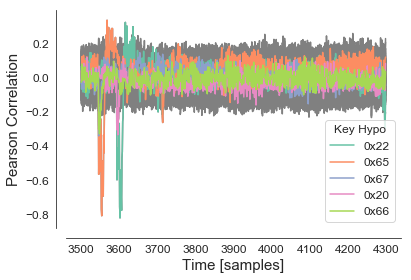

In [17]:
BYTE = 0
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
sns.set_style("white")
sns.set_palette(sns.color_palette("Set2"))
round2(BYTE,True)
plt.legend(loc="lower right",title="Key Hypo")
plt.xlabel('Time [samples]',FontSize=15)
plt.ylabel('Pearson Correlation',FontSize=15)
sns.despine(offset=10)

Or you can recover all four constants of the second round with the code below.
We us the location of the maximum correlation peak to decide which constant belongs to which byte.

In [18]:
constants = [0]*4
for byte in tqdm_notebook([0,2,3]):
    k1,k2,i1,i2 = round2(byte,False)
    if byte==0: # we know this gives two winning constants
        if i2<i1: # we check the location of the maximum correlation peak
            (k1,k2)=(k2,k1)
        constants[0]=k1
        constants[1]=k2
    else:
        constants[byte]=k1

In [19]:
print [hex(c) for c in constants]

['0x65', '0x22', '0x52', '0x52']


## Round 3
In this round, the results start depending on the nonce.
We can choose here to either use the full set of traces, or only use half or to make a specific subset based on the knowledge of the 7 least significant bits of the nonce. In that case, we can either guess that the eight bit is 0 or 1. By trying out these possibilities for one byte, it becomes clear what is the best option to use.

In [20]:
ind = [0,0,0,0,3,3,3,3,2,2,2,2,1,1,1,1]
factors2 = [2,1,1,3,1,1,3,2,1,3,2,1,3,2,1,1]
TRYFULL=0
TRYHALF=0
GUESSMSB=1
if TRYFULL:
    # use the full set of traces, but never use more than 256 for this step.
    subset = range(np.minimum(256,nr_of_meas))
elif TRYHALF:
    # try to use only half the traces
    subset = range(np.minimum(256,nr_of_meas/2))
else:
    nonce2 = (GUESSMSB<<7) | (nonce1&0x7F)
    print hex(nonce2)
    # 256-nonce2 is when X_{1,15} becomes 0 and X_{1,14} toggles. 
    # we try to create the perfect set of exactly 256 traces
    subset = range(256-nonce2, np.minimum(512-nonce2,nr_of_meas))
    # but if not enough traces are available, it might be better to take the first part of the traces
    if len(range(256-nonce2))>len(subset):
        subset = range(256-nonce2)
sub_nr_of_meas = len(subset)

0x8d


In [21]:
def round3(byte,plotit):
    maxcors = np.empty(256)
    cors = np.empty((256,len(x_range3)))
    hypos = np.empty(nr_of_meas)
    for guess in tqdm_notebook(range(256)):
        for i in range(nr_of_meas):
            alpha = sbox[key1^((nonce1+i)&0xff)]
            column1 = [sbox[mixcol(alpha,f,c)] for (f,c) in zip(factors,constants)]
            hypos[i] = hw[sbox[mixcol(column1[ind[byte]],factors2[byte],guess)]]
        cors[guess] = [pearsonr(powertraces[subset,j],hypos[subset])[0] for j in x_range3]
        if(plotit): plt.plot(x_range3,cors[guess],color="grey")
        maxcors[guess] = np.max(np.abs(cors[guess]))
    ranked_guesses = sorted(range(256), key=lambda k: maxcors[k], reverse=True)
    if(plotit):
        for g in ranked_guesses[:5]:
            print hex(g), maxcors[g]
            plt.plot(x_range3,cors[g],label="0x%02x"%g)
        plt.legend(loc="right")
    return ranked_guesses[0], ranked_guesses[1], np.argmax(np.abs(cors[ranked_guesses[0]])), np.argmax(np.abs(cors[ranked_guesses[1]]))

You can see the results of attacking one byte here by choosing BYTE $\in \{0,...,15\}$.
Remember that those with MixColumns factor 1 go together so they give the same results.


0xb9 0.8582007142510497
0x89 0.40855034809515833
0x70 0.3830903856953997
0xba 0.36780741324384236
0xe5 0.36238836466233926


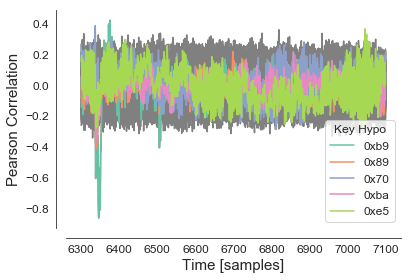

In [22]:
BYTE = 0
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
sns.set_style("white")
sns.set_palette(sns.color_palette("Set2"))
round3(0,True)
plt.legend(loc="lower right",title="Key Hypo")
plt.xlabel('Time [samples]',FontSize=15)
plt.ylabel('Pearson Correlation',FontSize=15)
sns.despine(offset=10)

Or you can recover all 16 constants of the second round with the code below.
We us the location of the maximum correlation peak to decide which constant belongs to which byte.

In [23]:
constants2 = [0]*16
for byte in tqdm_notebook([0,1,3,4,6,7,8,9,10,12,13,14]):
    k1,k2,i1,i2 = round3(byte,False)
    if byte in [1,4,8,14]:
        if i2<i1:
            (k1,k2)=(k2,k1)
        if byte==8:
            constants2[8]=k1
            constants2[11]=k2
        else:
            constants2[byte]=k1
            constants2[byte+1]=k2
    else:
        constants2[byte]=k1

In [24]:
print [hex(c) for c in constants2]

['0xb9', '0xa9', '0x78', '0x8b', '0x53', '0x25', '0x57', '0x1b', '0xbe', '0xca', '0x7d', '0x6f', '0xd5', '0xfb', '0x82', '0x7c']


## Round 4
In the last round of the attack, we know all the state bytes. We use the same subset of traces as in part 3.

In [25]:
# some shiftrows indices 
SR = [0,5,10,15,4,9,14,3,8,13,2,7,12,1,6,11]
# a function to get the output of mixcolumns at the byte in column byte/4 and row byte%4
def get_mc_byte(state,byte):
    column = state[(byte/4)*4:(byte/4+1)*4]
    return timestwo(column[byte%4])^timesthree(column[(1 + byte%4)%4])^column[(2 + byte%4)%4]^column[(3 + byte%4)%4]

In [26]:
def round4(byte,plotit):
    maxcors = np.empty(256)
    cors = np.empty((256,len(x_range4)))
    hypos = np.empty(nr_of_meas)
    for guess in tqdm_notebook(range(256)):
        for i in range(nr_of_meas):
            alpha = sbox[((nonce1+i)&0xff)^key1]
            column1 = [sbox[mixcol(alpha,f,c)] for (f,c) in zip(factors,constants)]
            state = [sbox[mixcol(column1[ind[b]],factors2[b],constants2[b])] for b in SR]
            hypos[i] = hw[sbox[get_mc_byte(state,byte)^guess]]
        cors[guess] = [pearsonr(powertraces[subset,j],hypos[subset])[0] for j in x_range4]
        if(plotit): plt.plot(x_range4,cors[guess],color="grey")
        maxcors[guess] = np.max(np.abs(cors[guess]))
    ranked_guesses = sorted(range(256), key=lambda k: maxcors[k], reverse=True)
    if(plotit):
        for g in ranked_guesses[:5]:
            print hex(g), maxcors[g]
            plt.plot(x_range4,cors[g],label="0x%02x"%g)
        plt.legend(loc="right")
    return ranked_guesses[0]

The following code shows the results for attacking one byte of the round key.
If at this point there is no clear winner in the correlations, then something must be wrong with the results from the previous round. Best verify the subset of traces that is used.


0x7b 0.8941485228618821
0xb4 0.41545987149397146
0x4e 0.40006560611569814
0x6b 0.36655975187498196
0x56 0.36150131658409546


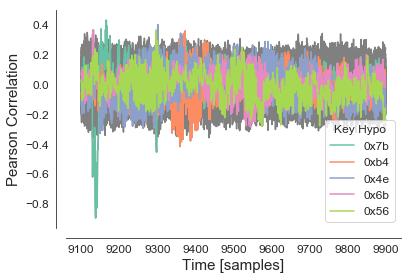

In [27]:
BYTE = 0
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
sns.set_style("white")
sns.set_palette(sns.color_palette("Set2"))
round4(BYTE,True)
plt.legend(loc="lower right",title="Key Hypo")
plt.xlabel('Time [samples]',FontSize=15)
plt.ylabel('Pearson Correlation',FontSize=15)
sns.despine(offset=10)

And the following code recovers all bytes. 

In [28]:
rndkey = [0]*16
for byte in tqdm_notebook(range(16)):
    k = round4(byte,False)
    rndkey[byte]=k

In [29]:
print [hex(k) for k in rndkey]

['0x7b', '0xff', '0x7a', '0xd7', '0xd', '0x28', '0x2e', '0xe3', '0x0', '0x3e', '0xd1', '0x58', '0xcb', '0x87', '0xb', '0xbb']


## Finish up
Finally, we perform backward key schedule and AES rounds to recover the master key.

In [30]:
Rcon = [0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1b, 0x36]

In [31]:
def prevkey(RoundKeyIn,rnd):
    RoundKey = RoundKeyIn[:]
    RoundKey[12]  = RoundKey[12] ^ RoundKey[8];
    RoundKey[13]  = RoundKey[13] ^ RoundKey[9];
    RoundKey[14]  = RoundKey[14] ^ RoundKey[10];
    RoundKey[15]  = RoundKey[15] ^ RoundKey[11];
    RoundKey[8]   = RoundKey[8] ^ RoundKey[4];
    RoundKey[9]   = RoundKey[9] ^ RoundKey[5];
    RoundKey[10]  = RoundKey[10] ^ RoundKey[6];
    RoundKey[11]  = RoundKey[11] ^ RoundKey[7];
    RoundKey[4]   = RoundKey[4] ^ RoundKey[0];
    RoundKey[5]   = RoundKey[5] ^ RoundKey[1];
    RoundKey[6]   = RoundKey[6] ^ RoundKey[2];
    RoundKey[7]   = RoundKey[7] ^ RoundKey[3];
    RoundKey[0]   = RoundKey[0] ^ sbox[RoundKey[13]] ^ Rcon[rnd];
    RoundKey[1]   = RoundKey[1] ^ sbox[RoundKey[14]];
    RoundKey[2]   = RoundKey[2] ^ sbox[RoundKey[15]];
    RoundKey[3]   = RoundKey[3] ^ sbox[RoundKey[12]];
    return RoundKey

In [32]:
rndkey2 = prevkey(rndkey,2)
print "Round key 2:", [hex(k) for k in rndkey2]
rndkey1 = prevkey(rndkey2,1)
print "Round key 1:", [hex(k) for k in rndkey1]
key = prevkey(rndkey1,0)
print "Round key 0 = Master key: ", [hex(k) for k in key]

Round key 2: ['0x29', '0xa8', '0x6b', '0xc8', '0x76', '0xd7', '0x54', '0x34', '0xd', '0x16', '0xff', '0xbb', '0xcb', '0xb9', '0xda', '0xe3']
Round key 1: ['0x52', '0x97', '0x1', '0x7c', '0x5f', '0x7f', '0x3f', '0xfc', '0x7b', '0xc1', '0xab', '0x8f', '0xc6', '0xaf', '0x25', '0x58']
Round key 0 = Master key:  ['0xcc', '0x8e', '0xf', '0x6', '0xd', '0xe8', '0x3e', '0x80', '0x24', '0xbe', '0x94', '0x73', '0xbd', '0x6e', '0x8e', '0xd7']


With this result, we can already verify our assumed result of the least significant master key byte. If the least significant 7 bits do not match, something definitely went wrong. 

Next, we recreate the first hypothesis of the state bytes in round 4 and work backwards to recover the nonce.

In [33]:
column1 = [sbox[mixcol(sbox[nonce1^key1],f,c)] for (f,c) in zip(factors,constants)]
state = [sbox[mixcol(column1[ind[b]],factors2[b],constants2[b])] for b in SR]
rndinput3 = [get_mc_byte(state,byte) for byte in range(16)]
print [hex(x) for x in rndinput3]

['0xa8', '0xc4', '0xc2', '0x4c', '0xc3', '0xfb', '0x24', '0x94', '0x14', '0x81', '0xc5', '0xff', '0x3e', '0xd8', '0xdf', '0x20']


In [34]:
def invshiftrows(statein):
    state = statein[:]
    tmp       = state[1];
    state[1]   = state[13];
    state[13]   = state[9];
    state[9]  = state[5];
    state[5]  = tmp;
    tmp       = state[2];
    state[2]   = state[10];
    state[10]  = tmp;
    tmp       = state[6];
    state[6]   = state[14];
    state[14]  = tmp;
    tmp       = state[3];
    state[3]   = state[7];
    state[7]  = state[11];
    state[11]  = state[15];
    state[15]   = tmp;
    return state
def invmix1column(x0, x1, x2, x3):
    return timeseight(x0^x1^x2^x3) ^ timesfour(x0^x2) ^ timestwo(x0^x1) ^ x1 ^ x2 ^ x3;
def invmixcolumns(columnin):
    column = columnin[:]
    tmp = column[:]
    column[0] = invmix1column(tmp[0],tmp[1],tmp[2],tmp[3]);
    column[1] = invmix1column(tmp[1],tmp[2],tmp[3],tmp[0]);
    column[2] = invmix1column(tmp[2],tmp[3],tmp[0],tmp[1]);
    column[3] = invmix1column(tmp[3],tmp[0],tmp[1],tmp[2]);
    return column

In [35]:
def invround(statein,k):
    state = statein[:]
    for i in range(4):
        state[(4*i):(4*i+4)] = invmixcolumns(state[(4*i):(4*i+4)])
    state=invshiftrows(state)
    for i in range(16):
        state[i] = sbox_inv[state[i]]
    for i in range(16):
        state[i] = state[i]^k[i]
    return state
def invhalfround(statein,k):
    state=statein[:]
    state = invshiftrows(state)
    for i in range(16):
        state[i] = sbox_inv[state[i]]
    for i in range(16):
        state[i] = state[i]^k[i]
    return state

In [36]:
rndinput2 = invround(rndinput3,rndkey2)
rndinput1 = invround(rndinput2,rndkey1)
nonce = invround(rndinput1,key)
print "First round input:", [hex(x) for x in nonce]

First round input: ['0xe6', '0x10', '0x3b', '0x22', '0x55', '0x62', '0x7e', '0xe6', '0xbe', '0x93', '0x18', '0xbd', '0x71', '0xb7', '0xbb', '0x8d']


We can now confirm whether also our assumption for the least significant nonce byte was correct.
#### Pay attention!
Because depending on when $X_{1,14}$ toggles, we might have recoverd $N_{14}$ or $N_{14}+1 \mod 256$. 
We perform the following check:

In [37]:
nbtracesbeforetoggle = 256-(nonce[15]+subset[0])
nbtracesaftertoggle = sub_nr_of_meas-nbtracesbeforetoggle
if nbtracesaftertoggle>nbtracesbeforetoggle:
    nonce[14] = (nonce[14]-1)%256
print [hex(x) for x in nonce]

['0xe6', '0x10', '0x3b', '0x22', '0x55', '0x62', '0x7e', '0xe6', '0xbe', '0x93', '0x18', '0xbd', '0x71', '0xb7', '0xba', '0x8d']


Now we have recoverd the nonce.

# Extra
Now that we know the key and nonce, we can make a plot showing the relationship between the actual hamming weights in the computation and the leaked measurement.

1482
-0.0021152496337890616 0.05387878417968748


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':


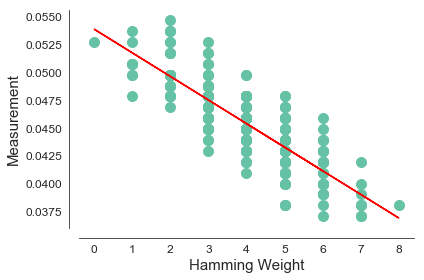

In [39]:
hypos = [hw[sbox[key1^((nonce1+i)&0xFF)]] for i in range(nr_of_meas)]
cor = [pearsonr(powertraces[:,j],hypos)[0] for j in range(len_trace)]
traceindex = np.argmax(np.abs(cor))
print traceindex
x = np.array(hypos)
y = powertraces[:,traceindex]
# least squares:
A = np.zeros((nr_of_meas,2))
A[:,0] = x
A[:,1] = 1
b = y
alpha_guess,beta_guess = lstsq(A,b)[0]
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
sns.set_style("white")
sns.set_palette(sns.color_palette("Set2"))
plt.plot(x,y, 'o', label='Data', markersize=10)
plt.plot(x, (alpha_guess*x + beta_guess), 'r', label='Fitted line')
plt.xlabel('Hamming Weight',FontSize=15)
plt.ylabel('Measurement',FontSize=15)
sns.despine(offset=10)
print alpha_guess,beta_guess